<a href="https://colab.research.google.com/github/TuringCollegeSubmissions/ggedvi-DL.2.5/blob/master/toxic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Part

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_lightning

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install contractions

In [19]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords
import contractions
import shutil

import torch
import torch.nn as nn
from torch.nn import Sigmoid
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
from transformers.optimization import get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, MulticlassAUROC, BinaryAUROC
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
from torch import cuda
from wordcloud import WordCloud


pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 199)
print("Setup complete")

Setup complete


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Sprint 2: Natural Language Processing

## Toxic comment challenge



The aim of this work is to create a tool to help to sort the forum comments made, with particular attention to the negative and the toxic ones.

The model is based on the following data set: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

The aim of this work is to build a multi-label classifier, to assign forum posts to one or more of the 6 classes:
    **toxic, severe_toxic, obscene, threat, insult, identity_hate.**



*  Here are functions to preprocess data for my model:<br>
Special characters for emoticons and icons are removed, URLs, non-English characters are removed, stop words are removed, abbreviations are changed, but words that are capitalised, the exclamation mark and the plural dots are kept. Also, I will remove rows that are duplicated.

In [6]:
def remove_emoji_characters(text):
    """
    Remove special special characters, including symbols, emojis, and other
     graphic characters
    """
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002702-\U000027B0"  # various icons
        "\U000024C2-\U0001F251"  # various icons and emojis
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)


def remove_special_character(text):
    """
    Remove special characters, leave multiple dots and exclamation marks.
    Remove extra white spaces.
    Remove single dots at the end of the sentence

    """
    cleaned_text = re.sub(r"[^a-zA-Z0-9.!]+", " ", text)
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    cleaned_text = re.sub(r"(?<=\w)\.", "", cleaned_text)
    return cleaned_text


def remove_non_ascii(text):
    """Use a regular expression to remove non-ASCII characters"""
    ascii_only = re.sub(r"[^\x00-\x7f]", "", text)
    return ascii_only


def remove_url(text):
    """Removing URL's"""
    return re.sub(r"https?://\S+|www\.\S+", "", text)


def remove_html_tags(text):
    clean = re.sub(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});", "", text)
    return clean


def process_lower_case(text):
    """change characters to lower case, keep all caps words"""

    words = re.split(r"(\s+|\.+)", text)
    processed_words = []

    for i, word in enumerate(words):
        if word.isupper() or (i<len(words) - 1 and words[i + 1].count(".")>0):
            processed_words.append(word)
        else:
            processed_words.append(word.lower())

    processed_text = " ".join(processed_words)
    return processed_text


def remove_stopwords(text):
    """Remove stopwords"""
    stop_words = set(stopwords.words("english"))
    words = text.split()
    clean_words = [word for word in words if (word not in stop_words)]
    return " ".join(clean_words)


def contraction_expansion(text):
    """Expansion of english contractions"""
    return contractions.fix(text)

In [7]:
def data_cleaning(text):
    text = remove_url(text)
    text = remove_html_tags(text)
    text = remove_non_ascii(text)
    text = remove_emoji_characters(text)
    text = contraction_expansion(text)
    text = process_lower_case(text)
    text = remove_special_character(text)
    text = remove_stopwords(text)
    return text

In [8]:
def remove_duplicates(df):
    df_no_duplicates = df.drop_duplicates(subset="comment_text")
    return df_no_duplicates

# The Data Presentation

File descriptions:<br>
* **train.csv** - the training set, contains comments with their binary labels;
* **test.csv** - the test set, to deter hand labeling, the test set contains some comments which are not included in scoring and it means they will be labeled as -1;
* **sample_submission.csv** - a sample submission file for kaggle competition - it is not useful in this project;
* **test_labels.csv** - labels for the test data; value of -1 indicates it was not used for scoring.

In [20]:
train_data = "/content/drive/MyDrive/Toxic_data/train_data/train.csv"
df_train = pd.read_csv(train_data)
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't rem...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more abou...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need ti...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [21]:
test_data = (
"/content/drive/MyDrive/Toxic_data/test_data/test.csv")
test_labels = (
"/content/drive/MyDrive/Toxic_data/test_labels_data/test_labels.csv")

df_test = pd.read_csv(test_data)
labels = pd.read_csv(test_labels)
df_test = pd.merge(df_test, labels, on='id')
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. J...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO.",-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for you...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


* The dataset description say that class labels with value of -1 indicates it was not used for scoring, therefore I will delete these:

In [22]:
df_test = df_test[(df_test != -1).all(axis=1)]
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up t...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a type. The """"Type"""" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting In...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wikipedia entry already, """"proving"""" it's relevance ...",0,0,0,0,0,0


* For general convenience I will concat both tables into one (this will make it easier to 'catch' duplicated comments):

In [23]:
df = pd.concat([df_train, df_test])
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't rem...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more abou...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need ti...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


* Combined dataset has no missing values and has 8 columns, 6 of those are our target labels and "comment_text" column is our raw source data:

In [ ]:
df.shape

(223549, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223549 entries, 0 to 153156
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 15.3+ MB


In [24]:
target_labels = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]

* How many comments that are neutral or not labeled at all:

In [25]:
zero_labels_count = (df[target_labels] == 0).all(axis=1).sum()
print("Number of comments without labels: ", zero_labels_count)

Number of comments without labels:  201081


* How many comments that have at least 1 label:

In [26]:
at_least_one_label_count = (df[target_labels] != 0).any(axis=1).sum()
print("Number of toxic comments with at least 1 label: ",\
      at_least_one_label_count)

Number of toxic comments with at least 1 label:  22468


* It appears We have to deal with unbalanced comment quantity, so to balance unlabeled comments I will undersample those and make more balanced dataframe (the same quantity as comments that are labeled once):

In [27]:
zero_labels_df = df[(df[target_labels] == 0).all(axis=1)]
at_least_one_label_count = df[(df[target_labels] != 0).any(axis=1)]
undersampled_zero_labels = zero_labels_df.sample(
    n=len(at_least_one_label_count), random_state=42
)


In [28]:
df = pd.concat([at_least_one_label_count, undersampled_zero_labels])
df.shape

(44936, 8)

* We know that we have multilabel prediction challenge, but to note that distribution of multi-label shows overlapping in this plot:<br>
Most comments are marked as toxic, the least comments are indicated as threat.

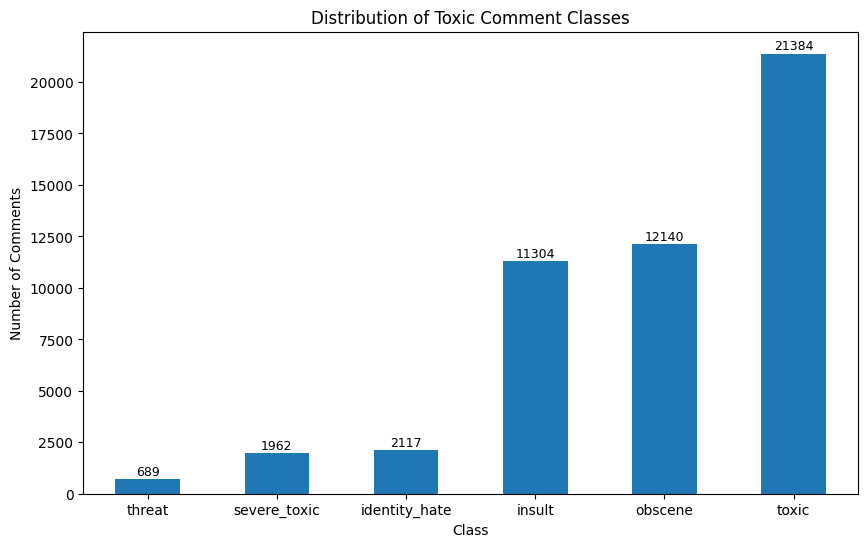

In [29]:
target_col = df[target_labels].sum(axis=0).sort_values()

plt.figure(figsize=(10, 6))
ax = target_col.plot(kind="bar")
for i, v in enumerate(target_col):
    ax.text(i, v + 50, str(v), ha="center", va="bottom", fontsize=9)
plt.title("Distribution of Toxic Comment Classes")
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.show()

* How many comments are unique per label:

In [30]:
df["unique_comment_per_label"] = df[target_labels].sum(axis=1) == 1

unique_label_counts = df.groupby("unique_comment_per_label")[target_labels].sum()

print("Counts of comments for each unique label:")
unique_label_counts

Counts of comments for each unique label:


,toxic,severe_toxic,obscene,threat,insult,identity_hate
unique_comment_per_label,,,,,,
False,14008,1962,11774,662,10939,2049
True,7376,0,366,27,365,68


* I will print out comments for each label as exhample (except 'severe_toxic' labeled comments, since it has no unique representation):

In [33]:
unique_labeled_df = df[df["unique_comment_per_label"]]
for label in target_labels:
    print(f"\nTop 3 comments for label '{label}':")

    top_comments = (
        unique_labeled_df[unique_labeled_df[label] == 1]["comment_text"]
        .head(3)
        .tolist()
    )

    for i, comment in enumerate(top_comments, start=1):
        print(f"{i}. {comment}")


Top 3 comments for label 'toxic':
1. Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...
2. Bye! 

Don't look, come or think of comming back! Tosser.
3. I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82

Top 3 comments for label 'severe_toxic':

Top 3 comments for label 'obscene':
1. How do you know he is dead.  Its just his plane that crashed.  Jeezz, quit busting his nuts, folks.
2. Bleh. I'm all out of ideas. Is there really something wrong with the serv

* I will show you main words for each label. In this case we see how common are some words for each label since they are overlapping:

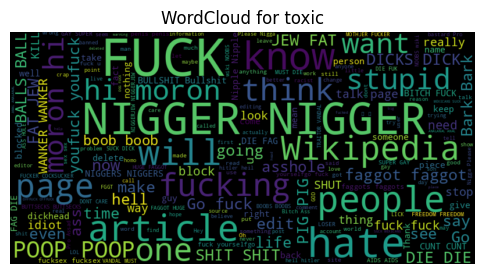

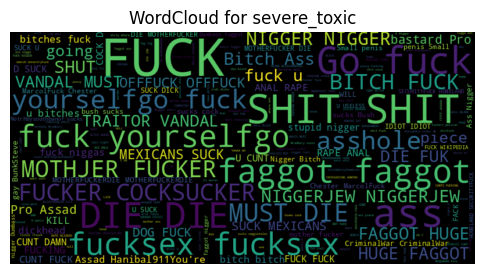

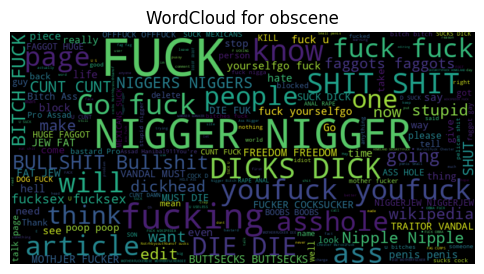

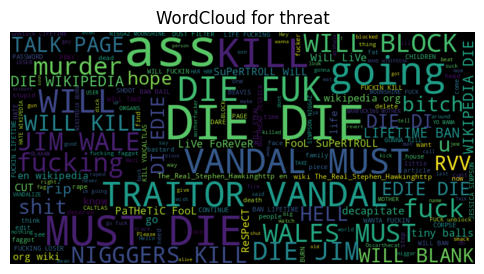

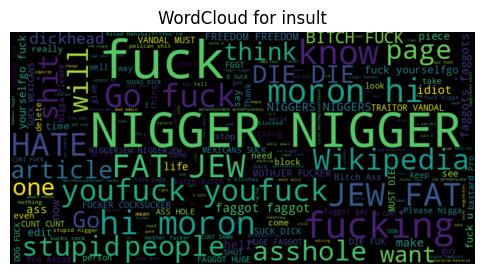

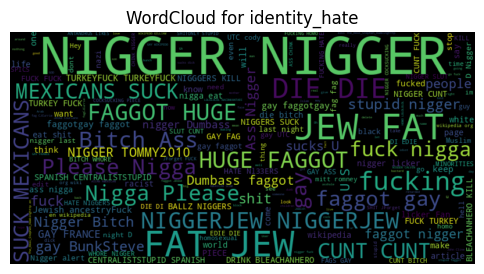

In [37]:
def generate_wordcloud(label):
    comments = df[df[label] == 1]["comment_text"].values
    text = " ".join(comments)

    wordcloud = WordCloud(width=800, height=400,stopwords=None, random_state=42, max_font_size=90).generate(text)

    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"WordCloud for {label}")
    plt.show()

for label in target_labels:
    generate_wordcloud(label)

* What is the average comment length for every target label before preprocess step:

In [ ]:
df["comment_length"] = df["comment_text"].apply(len)
df['comment_length'].describe()

count    44936.000000
mean       346.608554
std        613.333150
min          1.000000
25%         72.000000
50%        159.000000
75%        351.000000
max       5000.000000
Name: comment_length, dtype: float64

In [ ]:
result_dict = {}
for column in df[target_labels].columns:
    sum_comment_lengths = df[df[column] == 1]["comment_length"].sum()
    count_comments = df[df[column] == 1]["comment_length"].count()
    if count_comments > 0:
        mean_comment_length = sum_comment_lengths / count_comments
    else:
        mean_comment_length = 0
    result_dict[column] = {"mean_comment_length": mean_comment_length}

result_df = pd.DataFrame(result_dict).transpose()

print("Mean comment length for each target column:\n")
print(result_df)

Mean comment length for each target column:

               mean_comment_length
toxic                   280.604097
severe_toxic            505.456677
obscene                 280.951730
threat                  316.910015
insult                  272.206476
identity_hate           314.438829


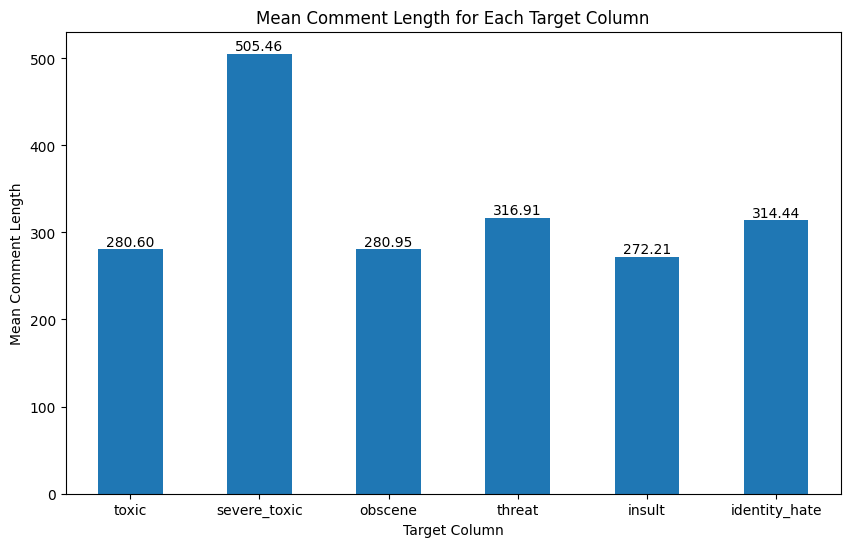

In [ ]:
plt.figure(figsize=(10, 6))
ax = result_df["mean_comment_length"].plot(kind="bar")
plt.title("Mean Comment Length for Each Target Column")
plt.xlabel("Target Column")
plt.ylabel("Mean Comment Length")
plt.xticks(rotation=0)
for i, value in enumerate(result_df["mean_comment_length"]):
    ax.text(i, value + 0.02, f"{value:.2f}", ha="center", va="bottom")
plt.show()

* I have made additional features that I will not need in modeling part, so just drop those:

In [ ]:
df.drop(
    labels=["id", "unique_comment_per_label", "comment_length"], axis=1,
    inplace=True
)

### EDA Part Conclusions:
    * For this project I concatenated given 2 datasets to preprocess and remove duplicated values;
    * We have 6 labels as target and they are overlapping between themselves: biggest group is toxic comments and smallest - threat;
    * Overall there are 201081 comments that are not labeled, so I have undersampled this group to the same quantity as comments with one label;
    * The average comment lengh varys from 272 to 505 per label.

# Modeling part

For this assignment I will use the recommended Distilbert model and DistilBertTokenizer as tokenizer.<br>
The work plan is:<br>
    * preprocess given dataset;<br>
    * tokenize text using DistilBertTokenize; <br>
    * the network will have the DistilBERT model. Follwed by a Droput and Linear Layer. They are for Regulariaztion and Classification.<br>
    * The number of targets for Linear Layer is 6 because that is the total number of our target labels.<br>
    * Final model layer outputs is what will be used to calcuate the loss and to get the accuracy of prediction.<br>
    * The trained model will be saved at its best validation dataset loss value.<br>
    * The loss function used will be a combination of Binary Cross Entropy which is implemented as BCELogits Loss in PyTorch;<br>
    * Optimizer AdamW is used to update the weights of the neural network to improve its performance.<br>
    * Schedule with a constant learning rate preceded by a warmup period during which the learning rate increases linearly between 0 and the initial lr set in the optimizer.<br>
    * Since it is multilabel classifikation I will use a Sigmoid activation to the output layer for each output to have its own and independent probability.<br>
    * I had a chance to run my model many times to take best parameters (like learning rate or dropout size);<br>
    * as model evaluation I chose ROC metrics and also F1 score.

* For this presentation I will imitate preprocess step to show how tokenisation works:

In [ ]:
df["comment_text"] = df["comment_text"].apply(data_cleaning)
remove_duplicates(df)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,Hey ... .. talk . ... exclusive group WP TALIBANS ... good destroying self appointed purist GANG UP one asks questions ANTI SOCIAL DESTRUCTIVE non contribution WP ask sityush clean behavior issue...,1,0,0,0,0,0
16,bye! look come think comming back! Tosser .,1,0,0,0,0,0
42,gay antisemmitian archangel white tiger meow! greetingshhh! uh two ways erased comment WW2 holocaust brutally slaying jews gays Gypsys Slavs anyone ... 1 anti semitian shave head bald go skinhead...,1,0,1,0,1,1
43,FUCK YOUR FILTHY MOTHER IN THE ASS DRY!,1,0,1,0,1,0
...,...,...,...,...,...,...,...
96810,porumbacu de jos problem domain . small question mind started article talk,0,0,0,0,0,0
6822,nice snark fun 400 lbs living Wikipedia . dad . N277 N brandenburg ave merrill wisconsin parents live,0,0,0,0,0,0
46951,texas ranger see badge last episode .,0,0,0,0,0,0
69512,april jeanette mendez,0,0,0,0,0,0


* Count number of tokens per comment: <br>

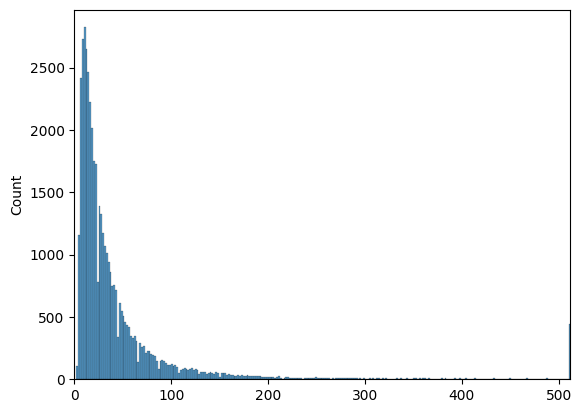

In [ ]:
MODEL_NAME = "distilbert-base-uncased"
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME)

token_counts = []
for _, row in df.iterrows():
    token_count = len(
        TOKENIZER.encode(row["comment_text"], max_length=512, truncation=True)
    )
    token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512])

* Bellow is the example of tokenized text:

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[target_labels]

encoding = TOKENIZER.encode_plus(
    sample_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.comment_text
sample_labels = sample_row[target_labels]
print(sample_comment)
print(sample_labels.to_dict())

UNBLOCK ME OR I WILL GET MY LAWYERS ON TO YOU FOR BLOCKING MY CONSTITUTIONAL RIGHT TO FREE SPEECH
{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


* The result of the encoding is a dictionary with token ids input_ids and an attention mask attention_mask

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([  101,  4895, 23467,  2033,  2030,  1045,  2097,  2131,  2026,  9559,
         2006,  2000,  2017,  2005, 10851,  2026,  6543,  2157,  2000,  2489])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

* Also we can get back the words from the token ids:

In [ ]:
print(TOKENIZER.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'un', '##block', 'me', 'or', 'i', 'will', 'get', 'my', 'lawyers', 'on', 'to', 'you', 'for', 'blocking', 'my', 'constitutional', 'right', 'to', 'free']


* after tokenization presentation I will prepare dataset for modeling part:

In [ ]:
df = pd.concat([at_least_one_label_count, undersampled_zero_labels])
df.drop("id", axis=1, inplace=True)

* We saw in the plot that token number exceeds 500 tokens. Threfore I need to take maximum tokens as 512:


In [ ]:
TARGET_COLUMNS = df.columns.tolist()[1:]
MAX_TOKEN_LEN = 512
N_EPOCHS = 6
BATCH_SIZE = 8
MODEL_NAME = 'distilbert-base-uncased'
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

* splitting dataset into 3 parts: train, validation and test datasets:

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.5)
train_df.shape, val_df.shape, test_df.shape

((35948, 7), (4494, 7), (4494, 7))

In [ ]:
class ToxicDataset(Dataset):
    def __init__(self, df, tokenizer, max_token_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        df_row = self.df.iloc[index]
        text = df_row.comment_text
        labels = df_row[TARGET_COLUMNS]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            truncation=True,
            padding="max_length",
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "comment_text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.FloatTensor(labels),
        }

In [ ]:
class ToxicDataloader(pl.LightningDataModule):
    def __init__(
        self, train_df, val_df, test_df, tokenizer, batch_size=8,
        max_token_len=128
    ):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

        self.train_df = self.preprocess_data(train_df)
        self.val_df = self.preprocess_data(val_df)
        self.test_df = self.preprocess_data(test_df)

    def preprocess_data(self, df):
        """Apply data cleaning and delete duplicates"""
        df["comment_text"] = df["comment_text"].apply(data_cleaning)
        df_no_duplicates = remove_duplicates(df)
        return df_no_duplicates

    def setup(self, stage):
        if stage == "fit":
            self.train_dataset = ToxicDataset(
                self.train_df, self.tokenizer, self.max_token_len
            )

            self.val_dataset = ToxicDataset(
                self.val_df, self.tokenizer, self.max_token_len
            )

        if stage in (None, "test", "predict"):
            self.test_dataset = ToxicDataset(
                self.test_df, self.tokenizer, self.max_token_len
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=2
        )

This is an instance to the created data loading module:

In [ ]:
data_container = ToxicDataloader(
    train_df,
    val_df,
    test_df,
    tokenizer=TOKENIZER,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_LEN,
)

In [ ]:
class ToxicCommentModel(pl.LightningModule):
    def __init__(self, n_classes, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.model = DistilBertModel.from_pretrained(MODEL_NAME,
                                                     return_dict=True)
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(768, 6)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.loss = nn.BCELoss()
        self.outputs = []

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.last_hidden_state[:, 0, :])
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.loss(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.outputs.append(outputs)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def on_training_epoch_end(self):
        labels = []
        predictions = []
        for output in self.outputs:
            for output_labels in output["labels"].detach().cpu():
                labels.append(output_labels)
            for output_predictions in output["predictions"].detach().cpu():
                predictions.append(output_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for item, name in enumerate(TARGET_COLUMNS):
            metric_roc_auc = AUROC(predictions[:, item], labels[:, item])
            self.logger.experiment.add_scalar(
                f"{name}_ROC_AUC/Train", metric_roc_auc, self.current_epoch
            )
        self.outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-06
        )
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps,
        )
        return dict(
            optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler,
                                                   interval="step")
        )

* To use the scheduler, we need to calculate the number of training and warm-up steps.

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

steps_per_epoch, total_training_steps

(4493, 26958)

* Now I make instance to the model:

In [ ]:
model = ToxicCommentModel(
  n_classes=len(TARGET_COLUMNS),
  n_warmup_steps=steps_per_epoch,
  n_training_steps=total_training_steps
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

* Creating checkpoint that saves the best model (based on validation loss);
* adding logger to follow progress;
* also early stopping with patience = 2.

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/checkpoints",
    filename="best_toxic_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
logger = TensorBoardLogger("toxic_logs", name="toxic_comment")
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

In [ ]:
trainer = pl.Trainer(
  accelerator="gpu",
  devices=1,
  logger=logger,
  callbacks=[early_stopping_callback, checkpoint_callback],
  max_epochs=N_EPOCHS,
  gradient_clip_val=1,
  enable_progress_bar=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_container)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type            | Params
---------------------------------------------------
0 | model          | DistilBertModel | 66.4 M
1 | pre_classifier | Linear          | 590 K 
2 | dropout        | Dropout         | 0     
3 | classifier     | Linear          | 4.6 K 
4 | loss           | BCELoss         | 0     
---------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.832   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 4492: 'val_loss' reached 0.16779 (best 0.16779), saving model to '/content/drive/MyDrive/checkpoints/best_toxic_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 8969: 'val_loss' reached 0.15870 (best 0.15870), saving model to '/content/drive/MyDrive/checkpoints/best_toxic_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 13446: 'val_loss' reached 0.15744 (best 0.15744), saving model to '/content/drive/MyDrive/checkpoints/best_toxic_checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 17923: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 22400: 'val_loss' was not in top 1


In [ ]:
trainer.test(model, data_container)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2157149463891983     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2157149463891983}]

* So my final choice of the best model is based on validation loss 0.15744;
* bellow I am checking if my model works with random text from dataset:

In [ ]:
print(trainer.checkpoint_callback.best_model_path)

In [ ]:
checkpoint_file = "/content/drive/MyDrive/checkpoints/best_toxic_checkpoint.ckpt"
trained_model = ToxicCommentModel.load_from_checkpoint(
    checkpoint_file, n_classes=len(TARGET_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

* Here I just print out labels with predicted values that are higher than 0.5 threshold:

In [ ]:
THRESHOLD = 0.5
test_comment = "lexfusco5 HE IS A BIG FAGGOTT AND DOES NOT KNOW HOW TO RUN A \
GODDAMN WEBSITE! THIS IS EDITED BY JOES ALL OVER THE WORLD BUT WHEN REAL PEOPLE\
LIKE MYSELF!"

input_ids = encoding["input_ids"].to(device)
attention_mask = encoding["attention_mask"].to(device)

encoding = TOKENIZER.encode_plus(
    test_comment,
    add_special_tokens=True,
    max_length=512,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt",
)

_, test_prediction = trained_model(input_ids, attention_mask)

test_prediction = test_prediction.cpu().detach().numpy()

for label, prediction in zip(TARGET_COLUMNS, test_prediction[0]):
    rounded_prediction = round(prediction, 2)
    if rounded_prediction < THRESHOLD:
        continue
    print(f"{label}: {rounded_prediction:.2f}")

toxic: 0.97
obscene: 0.94
insult: 0.89


* Lets evaluate our model using test set:

In [ ]:
trained_model = trained_model.to(device)
test_dataset = ToxicDataset(test_df, TOKENIZER, max_token_len=MAX_TOKEN_LEN)
predictions = []
labels = []
for item in tqdm(test_dataset):
    _, prediction = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device),
    )
    predictions.append(prediction.flatten())
    labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

100%|██████████| 4494/4494 [01:21<00:00, 55.01it/s]


For initial evaluation I chose accuracy metrics:

In [ ]:
metric = BinaryAccuracy()
metric(predictions, labels)

tensor(0.9624)

* We have an imbalanced dataset. For this sort of evaluation I use ROC metric for each target label:

In [ ]:
print("AUROC per target label")
for i, name in enumerate(TARGET_COLUMNS):
    tag_auroc = BinaryAUROC()
    tag = tag_auroc(predictions[:, i], labels[:, i])
    print(f"{name}: {tag:.2f}")

AUROC per target label
toxic: 0.99
severe_toxic: 0.97
obscene: 0.99
threat: 0.99
insult: 0.98
identity_hate: 0.99


The F1 score shows most clearly how our predicted results are distributed by class. To get a better result we simply need more data for our model.

In [ ]:
predicted_label = predictions.numpy()
true_label = labels.numpy()
predicted_label = np.where(predicted_label > THRESHOLD, 1, 0)
print(
    classification_report(
        true_label, predicted_label, target_names=TARGET_COLUMNS,
        zero_division=0
    )
)

               precision    recall  f1-score   support

        toxic       0.93      0.97      0.95      2130
 severe_toxic       0.63      0.43      0.51       198
      obscene       0.89      0.93      0.91      1210
       threat       0.89      0.82      0.85        67
       insult       0.83      0.88      0.86      1110
identity_hate       0.84      0.80      0.82       201

    micro avg       0.89      0.91      0.90      4916
    macro avg       0.84      0.81      0.82      4916
 weighted avg       0.88      0.91      0.90      4916
  samples avg       0.44      0.45      0.44      4916



Cnclusions:
The selected model with the available parameters (Dropout(0.2), learning rate 2e-5 etc.) achieved an accuracy of 0.15744 validation loss. The accuracy metric showed an accuracy of 0.9624, but since our database is very unbalanced, we used the ROC metric (commonly used to assess the performance of a binary classification model), which gave good results for each class (the goal is to predict 6 classes in total). However, the most accurate result is the F1 score, which suggests that, given the available parameters, the accuracy of the class prediction could be improved by increasing the amount of data.

Improvements:

Further study of the subject is generally needed. The performance of the model would benefit from a wider choice of parameters and combinations, as well as a deeper study and application of the data preprocess step.